In [107]:
%matplotlib inline
%run 'bin/notebook_utils.py'

import sys
import pprint
import cProfile

import matplotlib.pyplot as plt
import numpy             as np

import radical.utils     as ru
import radical.pilot     as rp
import radical.analytics as ra

from   radical.utils.profile import *
from   radical.pilot.states  import *

In [48]:
# Load wrangled data saved in .csv files for both synapse, microbenchmarks and gromacs.
sws_sessions = pd.read_csv('data/test_data/sessions.csv', index_col=0)
sws_pilots = pd.read_csv('data/test_data/pilots.csv', index_col=0)
sws_units = pd.read_csv('data/test_data/units.csv', index_col=0)


In [108]:
# Load wrangled data saved in .csv files for both orte, mpi-exec.

#orte_sessions = pd.read_csv('data/test_data/sessions.csv', index_col=0)
#orte_pilots = pd.read_csv('data/test_data/pilots.csv', index_col=0)
#orte_units = pd.read_csv('data/test_data/units.csv', index_col=0)

mpiexec_sessions = pd.read_csv('data/exp-1-orte-mpi-exec/mpi-exec/sessions.csv', index_col=0)
mpiexec_pilots = pd.read_csv('data/exp-1-orte-mpi-exec/mpi-exec/pilots.csv', index_col=0)
mpiexec_units = pd.read_csv('data/exp-1-orte-mpi-exec/mpi-exec/units.csv', index_col=0)



In [109]:
#print 'ORTE: exp1 : Total number of successful runs: %s' % orte_sessions.shape[0]
#print 'ORTE: exp1 : Total number of pilots: %s' % orte_pilots.shape[0]
#print 'ORTE: exp1 : Total number of units: %s\n' % orte_units.shape[0]

print 'MPIEXEC: exp1 : Total number of successful runs: %s' % mpiexec_sessions.shape[0]
print 'MPIEXEC: exp1 : Total number of pilots: %s' % mpiexec_pilots.shape[0]  ## number of pilots are not 2?!
print 'MPIEXEC: exp1 : Total number of units: %s\n' % mpiexec_units.shape[0]

MPIEXEC: exp1 : Total number of successful runs: 2
MPIEXEC: exp1 : Total number of pilots: 2
MPIEXEC: exp1 : Total number of units: 256



## Weak Scaling Results on SuperMic


In [115]:
sws = mpiexec_sessions[
    ['nunit','TTC','P_LRMS_QUEUING','U_AGENT_QUEUING','U_AGENT_SCHEDULING','U_AGENT_QUEUING_EXEC','U_AGENT_EXECUTING', #'util_u_pre_exec',
    'util_u_eprep','util_u_equeue','util_u_exec_cu','util_u_exec_rp']
        ].groupby(['nunit']).aggregate(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std'],
                # 'util_u_pre_exec'     : ['mean','std'],
                 'util_u_eprep'        : ['mean','std'],
                 'util_u_equeue'       : ['mean','std'],
                 'util_u_exec_cu'      : ['mean','std'],
                 'util_u_exec_rp'      : ['mean','std'],
               #  'util_u_pre_exec'     : ['mean','std']
                })

sws.rename({'util_u_eprep'        :'cu_prep'}, axis='columns', inplace=True)
sws.rename({'util_u_equeue'       :'scheduler_queue_cu'}, axis='columns', inplace=True)
sws.rename({'util_u_exec_cu'      :'os_spawns_cu'}, axis='columns', inplace=True)
sws.rename({'util_u_exec_rp'      :'executor_spawning_cu'}, axis='columns', inplace=True)
#sws.rename({'util_u_pre_exec'     :'pre_executables_cu'}, axis='columns', inplace=True)

sws.rename({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
sws.rename({'U_AGENT_QUEUING'     :'agent_queueing'}, axis='columns', inplace=True)
sws.rename({'U_AGENT_SCHEDULING'  :'agent_scheduling'}, axis='columns', inplace=True)
sws.rename({'U_AGENT_QUEUING_EXEC':'agent_queue_exec'}, axis='columns', inplace=True)
sws.rename({'U_AGENT_EXECUTING'   :'TTX'}, axis='columns', inplace=True)

sws.rename(index={i: '%s/%s' % (i/(65*4), i*8) for i in sws.index.get_values()}, inplace=True)
#sws

In [118]:
pws = mpiexec_pilots[
    ['nunit','util_p_total','util_p_boot','util_p_term','util_p_uexec']
        ].groupby(['nunit']).aggregate(
                {'util_p_total'        : ['mean','std'],
                 'util_p_boot'         : ['mean','std'],
                 'util_p_term'         : ['mean','std'],
                 'util_p_uexec'        : ['mean','std'],
                })


# 'orte_dvm_start'  is not captured in APRUN

pws.rename({'util_p_total'        :'p_total'}, axis='columns', inplace=True)
pws.rename({'util_p_boot'         :'p_bootstraps'}, axis='columns', inplace=True)
pws.rename({'util_p_term'         :'p_term'}, axis='columns', inplace=True)
pws.rename({'util_p_uexec'        :'p_uexec'}, axis='columns', inplace=True)

pws.rename(index={i: '%s/%s' % (i/(65*4), i*8) for i in pws.index.get_values()}, inplace=True)
#pws

In [119]:
keys = mpiexec_sessions['sid'].tolist()
values = mpiexec_sessions['nunit'].tolist()
nunits_dict = dict(zip(keys, values))

sids_list = mpiexec_units['sid'].tolist()
nunit = []

for i in sids_list:
    nunit.append(nunits_dict[i])

mpiexec_units['nunit']=nunit
mpiexec_units.set_index('sid')
uws = mpiexec_units[
    ['nunit','util_u_eprep','util_u_equeue','util_u_exec_rp', 'util_u_exec_app' , 'util_u_exec_cu', 'util_u_exec_orte', 'util_u_unschedule',
     'util_u_executor_to_launch_method', 'util_u_launch_method_to_executor'
     #'util_u_pre_exec'
    ]
        ].groupby(['nunit']).aggregate(
                {
                 'util_u_eprep'          : ['mean','std'],
                 'util_u_executor_to_launch_method' : ['mean','std'],
                 'util_u_launch_method_to_executor': ['mean','std'],
                 
                 
                })

uws.rename({'util_u_eprep'        :'cu_prep'}, axis='columns', inplace=True)
uws.rename({'util_u_equeue'       :'scheduler_queue_cu'}, axis='columns', inplace=True)
uws.rename({'util_u_exec_cu'      :'os_spawns_cu'}, axis='columns', inplace=True)
uws.rename({'util_u_exec_rp'      :'executor_spawning_cu'}, axis='columns', inplace=True)
uws.rename({'util_u_pre_exec'     :'pre_executables_cu'}, axis='columns', inplace=True)

uws.rename(index={i: '%s/%s' % (i/(65*4), i*8) for i in uws.index.get_values()}, inplace=True)
uws

cu_prep           util_u_executor_to_launch_method     util_u_launch_method_to_executor    
            mean       std                             mean std                             mean std
nunit                                                                                               
0/1024  0.004852  0.003053                              NaN NaN                              NaN NaN

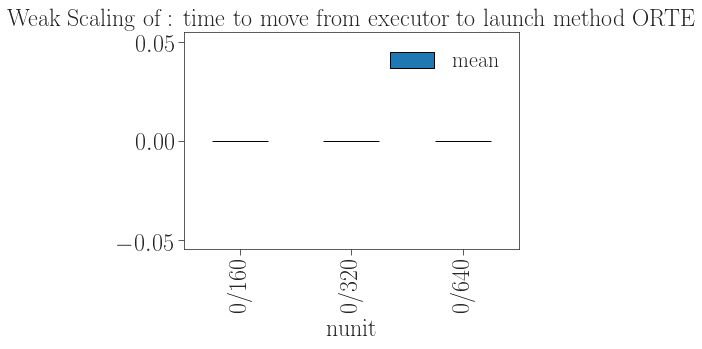

In [86]:
ax = uws['util_u_executor_to_launch_method'].reset_index().plot.bar(x='nunit', y='mean', yerr='std', title = 'Weak Scaling of : time to move from executor to launch method ORTE')

Text(0,0.5,'Time (s)')

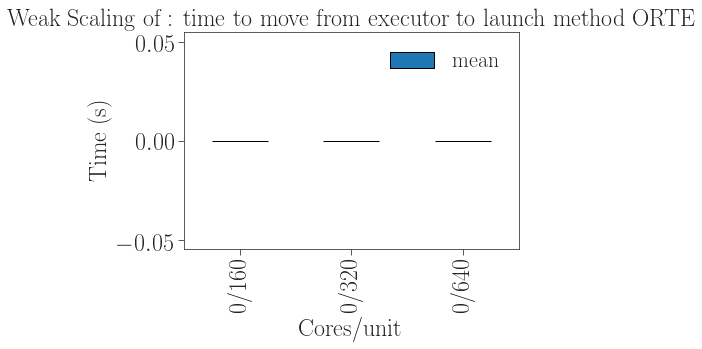

In [100]:
ax = uws['util_u_executor_to_launch_method'].reset_index().plot.bar(x = 'nunit', y = 'mean', yerr='std', title = 'Weak Scaling of : time to move from executor to launch method ORTE',
                                                                   )
ax.set_xlabel('Cores/unit')
ax.set_ylabel('Time (s)')

Text(0,0.5,'Time (s)')

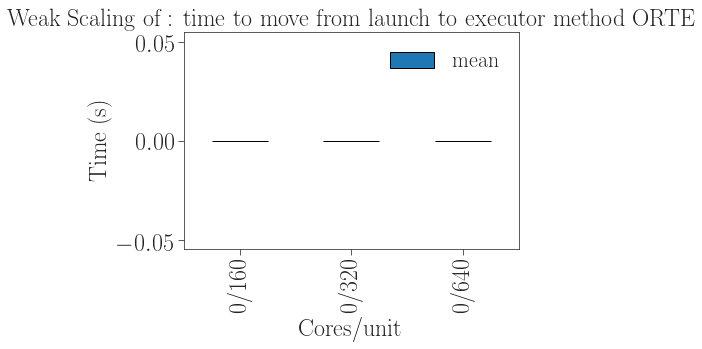

In [102]:
ax = uws['util_u_launch_method_to_executor'].reset_index().plot.bar(x = 'nunit', y = 'mean', yerr='std', title = 'Weak Scaling of : time to move from launch to executor  method ORTE',
                                                                   )

ax.set_xlabel('Cores/unit')
ax.set_ylabel('Time (s)')

## MPI-EXEC LAUNCH METHOD

Text(0,0.5,'Time (s)')

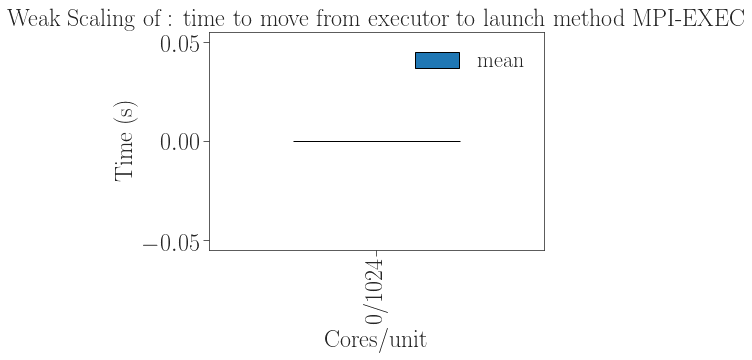

In [120]:
ax = uws['util_u_executor_to_launch_method'].reset_index().plot.bar(x = 'nunit', y = 'mean', yerr='std', title = 'Weak Scaling of : time to move from executor to launch method MPI-EXEC',
                                                                   )

ax.set_xlabel('Cores/unit')
ax.set_ylabel('Time (s)')

Text(0,0.5,'Time (s)')

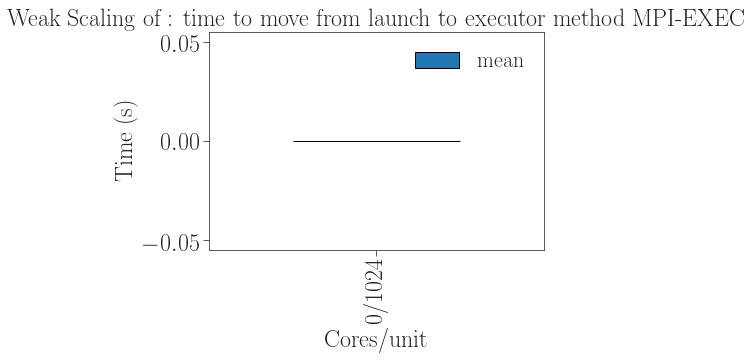

In [121]:
ax = uws['util_u_launch_method_to_executor'].reset_index().plot.bar(x = 'nunit', y = 'mean', yerr='std', title = 'Weak Scaling of : time to move from launch to executor  method MPI-EXEC',
                                                                   )

ax.set_xlabel('Cores/unit')
ax.set_ylabel('Time (s)')